# Data Engineering Project

#### Project Summary
The main purpose of this project is to create a database from different sources related to I94 immigration data set, in order to acheive this it will be created an ETL pipeline using airflow to feed a Redshift database with data stored in amazon s3. It will be created a schema so the data science can query in a efficient way.


In [30]:
# Do all imports and installs here
import pandas as pd
import psycopg2

import configparser
config = configparser.ConfigParser()
config.read('dl.cfg')

['dl.cfg']

### Scope the Project and Gather Data

#### Scope 

The main purpose of this project is to create an analytical database from the US National Tourism and Trade Office data including the U.S city demography. This will help the data scientist team to derive knowlegde from this dataset. The tools used in this project are Amazon S3, apache spark and Redshift.



#### Describe and Gather Data 

- I94 Immigration Data: This data comes from the US National Tourism and Trade Office. 
- U.S. City Demographic Data: This data comes from OpenSoft and contains information about the demographics in US.
- Airport Code Table: This is a table of airport codes and data relevant to the airport.
- Country Code Table: This is a table of country codes and its name.


### I94 Immigration Data:


In [31]:
fname = './data/immigration_data_sample.csv'
inmigrantsData = pd.read_csv(fname)
inmigrantsData.head()


,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


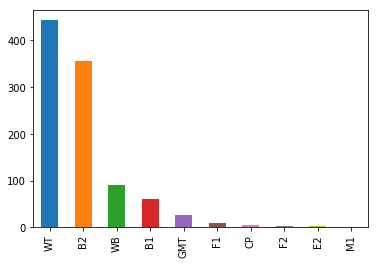

In [32]:
inmigrantsData["visatype"].value_counts().plot(kind="bar")


### Airport Codes

In [33]:
airportsData = pd.read_csv("./data/airport-codes_csv.csv")
airportsData.head()


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


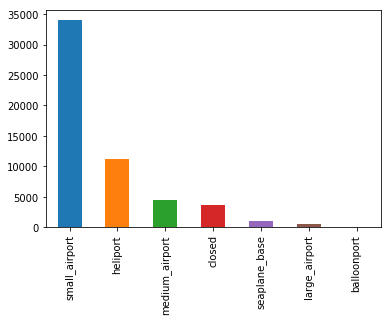

In [34]:
airportsData["type"].value_counts().plot(kind="bar")


### Country codes

In [35]:
countryCodes = pd.read_csv("./data/country-codes_csv.csv", sep=";")
countryCodes.head()


,CODE,COUNTRY
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


### U.S. City Demographic Data

In [36]:
demographicData = pd.read_csv("./data/us-cities-demographics.csv", sep=";")
demographicData.head()


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


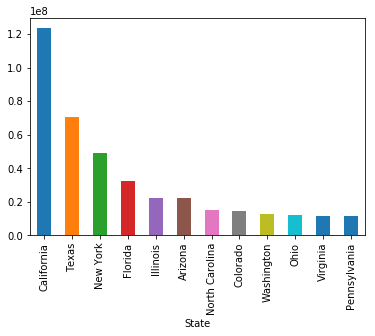

In [37]:
demographicData.groupby('State')['Total Population'].sum().nlargest(12).plot(kind="bar")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [38]:
inmigrantsData.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

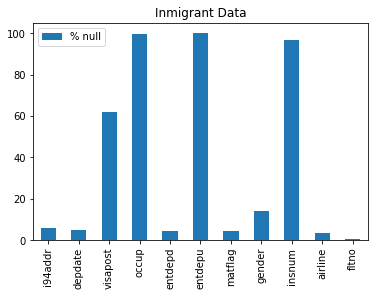

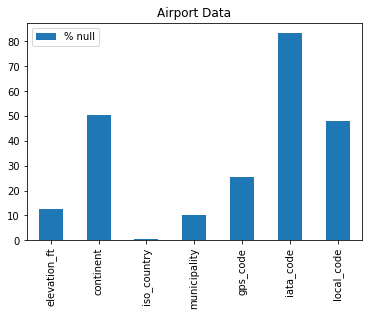

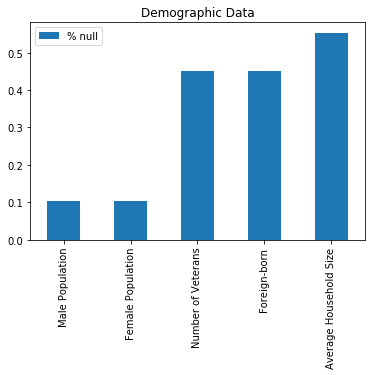

In [39]:
for key, df in {'Inmigrant Data': inmigrantsData, 'Airport Data': airportsData, 'Demographic Data': demographicData}.items():
    nullDict = {}
    for item, i in df.items():
        nullRows = i.isnull().sum()
        totalRows = i.notnull().sum() + nullRows
        if totalRows > 0 and nullRows > 0 :
            nullDict[item] = (nullRows / totalRows) * 100
    pd.DataFrame.from_dict(nullDict, orient='index', columns=["% null"]).plot(kind='bar', title=key)


#### Cleaning steps

 - Drop columns with more than 40% of missing values, given that can not be used to analytical purposes.

In [40]:

inmigrantsData.drop(columns=["visapost", "occup", "entdepu", "insnum"], inplace=True)

airportsData.drop(columns=["continent", "iata_code", "local_code"], inplace=True)

demographicData.drop(columns=["Number of Veterans", "Foreign-born", "Average Household Size"], inplace=True)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

![title](images/diagram.png)


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

It was used Airflow for creating the pipelines, given that files were already on S3 and it was needed to transform CSV and Parquet files into redshift. Airflow also gives flexibility to schedule dags to run the ETL pipeline in a given time.

The steps involved where:

- Deleting tables on redshift.
- Creating tables with their schema.
- Copying CSV and parquet files into redshift.
- Performing quality checks after populating tables.


![title](images/etl_dag_completed.PNG)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In airflow they were already created some data quality checks counting the completness of the inserted data. For demostration purpose it will be added a few more.

In [41]:
dbname = config['REDSHIFT']['dbName']
port = config['REDSHIFT']['port']
host = config['REDSHIFT']['host']
user = config['REDSHIFT']['user']
pwd = config['REDSHIFT']['pwd']


con=psycopg2.connect(dbname= dbname, host=host, port=port, user=user, password=pwd) 

cur = con.cursor()

In [42]:
tables = ["visa_codes", "us_cities_demographics", "states_codes", "country_codes", "airport_codes", "immigration"]


cur.execute("""
SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE' AND TABLE_CATALOG='dev'
""")
tablesInRedshift = []
test = cur.fetchall()
for i in test:
    if i[0] in tables:
        tablesInRedshift.append(i[0])
if (tablesInRedshift.sort() == tables.sort()):
    print("All tables loaded")
else:
    print("Some tables were not loaded")

recordsInTables = []
for table in tables:
    sql = """ SELECT count(*) from public.{}""".format(table)
    cur.execute(sql)
    query = cur.fetchone()
    recordsInTables.append(query[0] > 0)
    print("Table {} with {} records".format(table, query[0]))
    if (all(recordsInTables)):
        print("All tables with records")
    else:
        print("Some tables without records")
    
cur.close() 
con.close()

All tables loaded
Table airport_codes with 54897 records
All tables with records
Table country_codes with 289 records
All tables with records
Table immigration with 3096313 records
All tables with records
Table states_codes with 55 records
All tables with records
Table us_cities_demographics with 2891 records
All tables with records
Table visa_codes with 3 records
All tables with records


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

Inmigrant Table

| Field | Description         
| -: |-------------: 
|cicid|ID
|i94yr|Year 4 digits
|i94mon|Month 2 digits
|i94cit|ID for country
|i94res|ID for country
|i94port|ID of airport
|arrdate|Date from arrive
|i94mode|Mode of arrive 
|i94addr|State Code
|depdate|Departure Date 
|i94bir|Age of respondant
|i94visa|Category of visa
|count|Summary statistics
|entdepa|Arrival Flag
|entdepd|Departure Flag
|matflag| Match flag
|biryear| 4 digit year of birth
|dtaddto|Dateallowed to stay until
|gender|Gender
|airline|Airline used to arrive 
|admnum|Admission Number
|fltno|Flight number
|visatype|Class of admission legally


Visa Codes Table from SAS file

| Field | Description         
| -: |-------------: 
|Code|ID
|Type|Category (Business, Pleasure, Student)



Visa Codes US Cities Demography 

| Field | Description         
| -: |-------------: 
|city|City Name
|state|State Name
|median_age|Median age of the population
|male_population|Count of male population
|female_population|ount of female population
|total_population|Count of total population
|state_code|State code
|race|Respondent race
|count|Count of city's individual per race



State Codes from SAS file 

| Field | Description         
| -: |-------------: 
|Code|ID
|State|State Name



Country Codes from SAS file

| Field | Description         
| -: |-------------: 
|Code|ID
|Country|Country Name



Airpot Codes from SAS file

| Field | Description         
| -: |-------------: 
|ident|ID
|type|Airport type
|name|Airport name
|elevation_ft|Elevation
|continent|Continent
|iso_region|Country-State ID
|municipality|Municipality
|gps_code|GPS Code
|local_code|GPS local Code
|lat|Latitude
|long|Longitude



#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

Clearly state the rationale for the choice of tools and technologies for the project:

Amazon S3 was used to store the parquet and csv files, so it will be easier to update files on a future. Airflow is a tool easy to mantain and to document an ETL pipeline, it is very easy to integrate with S3 to copy data to redshift. Readshift is data warehouse that is very cost-effective, very easy to scale and allow run complex analytic queries.

Propose how often the data should be updated and why.

The immigration data is updated monthly, so the redshift table should be updated with this periodicity.

Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x:
     The storage of refshift should be increased
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 Apache airflow gives the flexibility to schedule and run the pipeline at a given time.
 * The database needed to be accessed by 100+ people
 Spark can be scaled very easily, so the redshift cluster should be increased to more nodes and also update the node types.